# Javier Blanco Cordero
Contact: javierblancordero@gmail.com
## causaLens - Code Test
27/06/2020

# 0. Helpers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from pandas.plotting import register_matplotlib_converters

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#from statsmodels.tsa import seasonal
#from statsmodels.tsa.stattools import kpss
from statsmodels.graphics import tsaplots
#from statsmodels.tsa._stl import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
import ephem

In [2]:
# https://rhodesmill.org/pyephem/quick.html#bodies
    
def get_AU_distance_to_moon(date):
    """Returns AU distance to earth-moon given a date"""
    moon = ephem.Moon
    return moon(date).earth_distance
    
def get_AU_distance_to_sun(date):
    """Returns AU distance to earth-sun given a date"""
    sun = ephem.Sun
    return sun(date).earth_distance

In [3]:
def get_phase_on_day(date):
  """Returns a floating-point number from 0-1. where 0=new, 1=full"""
  
  date = ephem.Date(date)
  nnm = ephem.next_new_moon    (date)
  pnm = ephem.previous_new_moon(date)

  lunation=(date-pnm)/(nnm-pnm)

  return (math.sin(math.pi*lunation))

In [4]:
sns.set()
plt.rcParams['figure.figsize'] = (20, 5)
register_matplotlib_converters()

In [5]:
def month_diff(a, b):
    return 12 * (a.year - b.year) + (a.month - b.month)

def year_diff(a, b):
    return (a.year - b.year)

In [6]:
def plot_AC_and_PAC(series, lags):
    fig, (ax1,ax2) = plt.subplots(1, 2)
    
    tsaplots.plot_acf(series, ax=ax1, lags=lags, alpha=.05)
    ax1.set_title('AC '+series.name)
    
    tsaplots.plot_pacf(series, ax=ax2, lags=lags, alpha=.05)
    ax2.set_title('PAC ' +series.name)
    plt.show()

In [7]:
def plot_residuals_distribution(total_residuals, train_residuals, test_residuals, lags):
    plt.plot(train_residuals.index, train_residuals, color='blue', alpha=.75, label='train')
    plt.plot(test_residuals.index, test_residuals, color='red', alpha=.75, label='test')
    plt.title('Residuals evolution', size=15)
    plt.axvline(train_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.legend()
    plt.show()
    
    fig, (ax1,ax2) = plt.subplots(1, 2)
    tsaplots.plot_acf(train_residuals, ax=ax1, lags=lags, alpha=.05, label='train', color='blue')
    tsaplots.plot_acf(test_residuals, ax=ax1, lags=lags, alpha=.05, label='test', color='red')
    ax1.set_title('Residuals Autocorrelation')
    
    ax2.set_title('Residuals Distribution')
    sns.distplot(train_residuals, ax=ax2, label='train', color='blue')
    sns.distplot(test_residuals, ax=ax2, label='test', color='red')
    plt.axvline(0, color='black', linewidth=1)
    
    plt.legend()
    plt.show()

# 1. Import data
### 1.1 Load data

In [8]:
main_df = pd.read_csv('Data/venezia.csv')

display(main_df.head())
main_df.info()

,datetime,level
0,1983-01-01 01:00:00,44.0
1,1983-01-01 02:00:00,35.0
2,1983-01-01 03:00:00,23.0
3,1983-01-01 04:00:00,10.0
4,1983-01-01 05:00:00,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289272 entries, 0 to 289271
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   datetime  289272 non-null  object 
 1   level     289272 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.4+ MB


In [10]:
date_column = 'datetime'
forecast_column = 'level'

### 2.1 First data checks

In [11]:
# Check available dates and intervals
main_df[date_column].values[:20]

array(['1983-01-01 01:00:00', '1983-01-01 02:00:00',
       '1983-01-01 03:00:00', '1983-01-01 04:00:00',
       '1983-01-01 05:00:00', '1983-01-01 06:00:00',
       '1983-01-01 07:00:00', '1983-01-01 08:00:00',
       '1983-01-01 09:00:00', '1983-01-01 10:00:00',
       '1983-01-01 11:00:00', '1983-01-01 12:00:00',
       '1983-01-01 13:00:00', '1983-01-01 14:00:00',
       '1983-01-01 15:00:00', '1983-01-01 16:00:00',
       '1983-01-01 17:00:00', '1983-01-01 18:00:00',
       '1983-01-01 19:00:00', '1983-01-01 20:00:00'], dtype=object)

In [12]:
# Count nulls
main_df.isna().sum()

datetime    0
level       0
dtype: int64

In [13]:
# Convert date column into datetime format
main_df[date_column] = pd.to_datetime(main_df[date_column], format='%Y-%m-%d %H', errors='coerce') #'%m/%d/%Y'

# Also, create a DateTimeIndex
main_df.index = pd.DatetimeIndex(main_df[date_column])
main_df.index.name = None

# Use to_numeric in case there´s presence of strings
for column in [forecast_column]+features:
    main_df[column] = pd.to_numeric(main_df[column], errors='coerce')

# Sort data out chronologically
main_df.sort_index(inplace=True)
display(main_df.head())
display(main_df.tail())

,datetime,level
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0


,datetime,level
2015-12-31 20:00:00,2015-12-31 20:00:00,-18.0
2015-12-31 21:00:00,2015-12-31 21:00:00,-14.0
2015-12-31 22:00:00,2015-12-31 22:00:00,-5.0
2015-12-31 23:00:00,2015-12-31 23:00:00,8.0
2016-01-01 00:00:00,2016-01-01 00:00:00,20.0


In [14]:
# Frequency seems hourly. Let´s double check
print('dataframe rows: ' + str(len(main_df.index.unique())))

print('hours elapsed: ' + str((main_df.index.max() - main_df.index.min()).days*24 + 1))

dataframe rows: 289267
hours elapsed: 289249


# 2. EDA

### 2.1 Check time series evolution

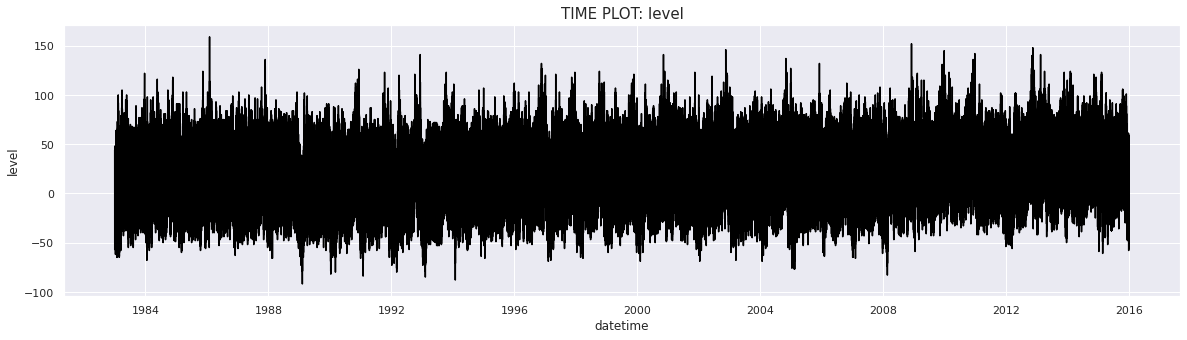

In [15]:
# Time plot: Original 
plt.title('TIME PLOT: '+forecast_column, size=15)
plt.ylabel(forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column], color='black')
plt.plot(main_df[date_column], main_df[forecast_column], color='black')
plt.show()

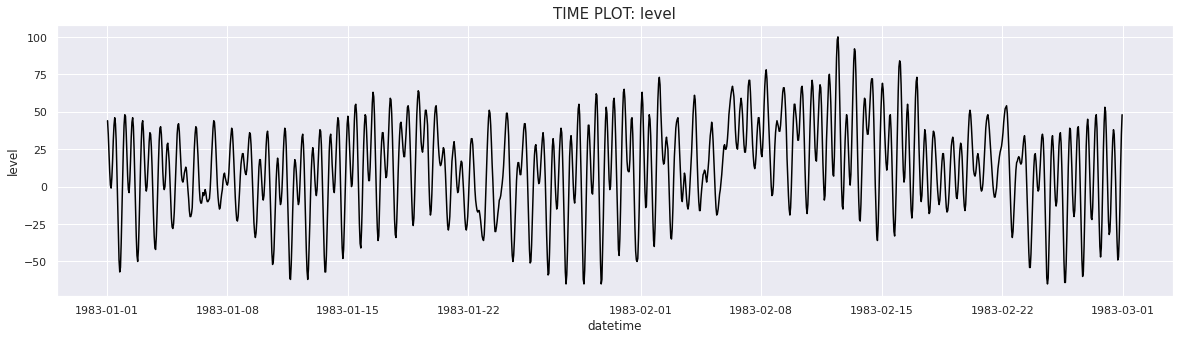

In [16]:
# Time plot: Original 
plt.title('TIME PLOT: '+forecast_column, size=15)
plt.ylabel(forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column], color='black')
plt.plot(main_df.loc[main_df.index<pd.to_datetime('19830301', format='%Y%m%d'), date_column], 
         main_df.loc[main_df.index<pd.to_datetime('19830301', format='%Y%m%d'), forecast_column], color='black')
plt.show()

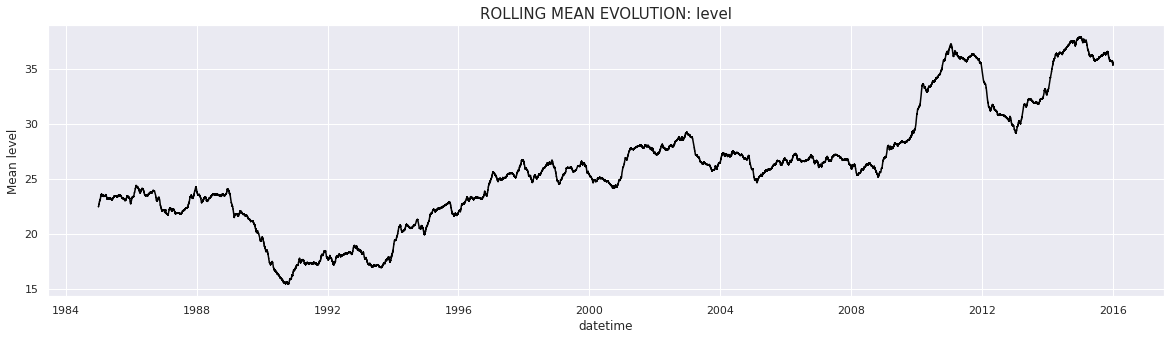

In [17]:
# Mean evolution: original
plt.title('ROLLING MEAN EVOLUTION: '+forecast_column, size=15)
plt.ylabel('Mean '+forecast_column)
plt.xlabel(date_column)
# plt.plot(ts[date_column], ts[forecast_column].rolling(6).mean(), color='black')
plt.plot(main_df[date_column], main_df[forecast_column].rolling(24*365*2).mean(), color='black')
plt.show()

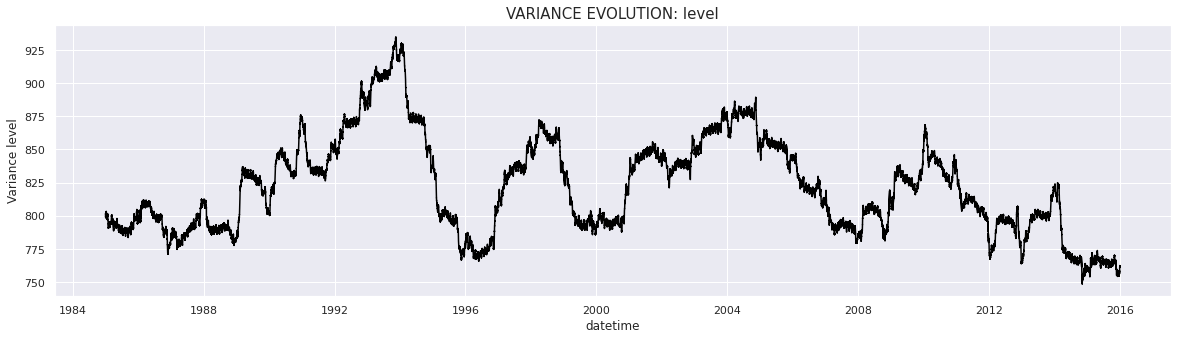

In [18]:
# Deviation evolution: original
plt.title('VARIANCE EVOLUTION: '+forecast_column, size=15)
plt.ylabel('Variance '+forecast_column)
plt.xlabel(date_column)
plt.plot(main_df[date_column], main_df[forecast_column].rolling(24*365*2).var(), color='black')
plt.show()

# 3. Data Transformations

In [19]:
main_df['moon_dist'] = [get_AU_distance_to_moon(date) for date in main_df.index]
main_df.head()

,datetime,level,moon_dist
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0,0.002394
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0,0.002395
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0,0.002396
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0,0.002396
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0,0.002397


In [20]:
main_df['sun_dist'] = [get_AU_distance_to_sun(date) for date in main_df.index]
main_df.head()

,datetime,level,moon_dist,sun_dist
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0,0.002394,0.983272
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0,0.002395,0.983271
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0,0.002396,0.983271
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0,0.002396,0.983271
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0,0.002397,0.983270


In [ ]:
main_df['moon_phase'] = [get_phase_on_day(date) for date in main_df.index]
main_df.head()

In [ ]:
main_df['sun_aceleration'] = (1.987E+10*6.67E-11)/((1.496E+11*main_df['sun_dist'])**2)

In [ ]:
main_df.head()

In [ ]:
x = main_df['sun_aceleration']
y = main_df['level']
plt.figure(figsize=(10,10))
plt.title('Correlation with sun_aceleration')
plt.scatter(x, y, label='Correlation with sun_aceleration', color='blue', alpha=0.25)
plt.text((x.max() - x.min()) / 2 + x.min(),
         (y.max()-y.min())/2+y.min(),
         str(round(scipy.stats.pearsonr(x, y)[0], 2)),
         verticalalignment='center', horizontalalignment='center', fontsize=180, color='white',
         alpha=0.65)  # coef corr)
plt.xlabel('Sun acc')
plt.ylabel('Level')
plt.show()

### 2.4 Autocorrelation

In [ ]:
# Autocorrelation and partial autocorrelation
plot_AC_and_PAC(main_df[forecast_column], lags=24*29) # Original

### 2.5 STL Decomposition

In [ ]:
# https://www.statsmodels.org/devel/examples/notebooks/generated/stl_decomposition.html
plt.rcParams['figure.figsize'] = 20,20
res = STL(main_df[forecast_column], period=24*365).fit()
fig = res.plot()
plt.show()
plt.rcParams['figure.figsize'] = (20, 5)

In [ ]:
# Strenth of components
# Reference: https://otexts.com/fpp2/seasonal-strength.html
Tt = getattr(res, 'trend') # smoothed trend component
St = getattr(res, 'seasonal') # seasonal component
Rt = getattr(res, 'resid') # remainder component

# Strenth of trend (0 - 1 | small - big trend)
Ft = max(0, 1-(np.var(Rt)/np.var(Tt+Rt)))
print("Strenth of trend: " +str(round(Ft,2)))

# Strenth of seasonality (0 - 1 | small - big seasonality)
Fs = max(0, 1-(np.var(Rt)/np.var(St+Rt)))
print("Strenth of seasonality: " +str(round(Fs,2)))

# Data Transformations

## .1 Differenciation

In [ ]:
lags = 12

In [ ]:
# https://otexts.com/fpp2/stationarity.html

# First order differencing
main_df['diff('+forecast_column+')'] = main_df[forecast_column] - main_df[forecast_column].shift(1)

# Second order differencing
main_df['diff(diff('+forecast_column+'))'] = main_df['diff('+forecast_column+')'] - (main_df[forecast_column].shift(1) - main_df[forecast_column].shift(2))


# Plotting
plot_AC_and_PAC(main_df[forecast_column], lags) # Original
plot_AC_and_PAC(main_df['diff('+forecast_column+')'].dropna(), lags) # First differencing
plot_AC_and_PAC(main_df['diff(diff('+forecast_column+'))'].dropna(), lags) # Second order differencing

In [ ]:
# https://otexts.com/fpp2/stationarity.html

# Seasonal differencing
main_df['lag-12 diff('+forecast_column+')'] = main_df[forecast_column] - main_df[forecast_column].shift(12)

# Second order differencing
main_df['diff(lag-12 diff('+forecast_column+'))'] = main_df['lag-12 diff('+forecast_column+')'] - (main_df[forecast_column].shift(1)-main_df[forecast_column].shift(13))

# Plotting
plot_AC_and_PAC(main_df[forecast_column], lags) # Original
plot_AC_and_PAC(main_df['lag-12 diff('+forecast_column+')'].dropna(), lags) # Seasonal differencing
plot_AC_and_PAC(main_df['diff(lag-12 diff('+forecast_column+'))'].dropna(), lags) # Seasonal differencing with further differencing

# 3 Model Fit

In [ ]:
len(train_df)

## 3.1 Train-test split

In [ ]:
separating_date = pd.to_datetime('20120101', format='%Y%m%d')
train_df = main_df.loc[main_df.index < separating_date]
mini_train_df = train_df[train_df.index < pd.to_datetime('19900101', format='%Y%m%d')]
test_df = main_df.loc[main_df.index >= separating_date]

# final_forecasting_date = pd.to_datetime('20200101', format='%Y%m%d')
# forecast_df = pd.DataFrame(
#     index = pd.date_range(start = main_df.index.max(), 
#                           end = final_forecasting_date, 
#                           freq='MS', closed='right') # frecuencies available https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
# )


# Visualise train test split
plt.title('Train - Test split')
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()

## 3.1 Linear Regression

In [ ]:
lm = linear_model.LinearRegression(fit_intercept=True)

In [ ]:
main_df.columns

In [ ]:
features = ['moon_dist', 'sun_dist', 'moon_phase', 'moon_dist*moon_phase', 'sun_aceleration']
lm.fit(train_df[features], train_df[forecast_column])

In [ ]:
y_train_pred = pd.Series(lm.predict(train_df[features]), index=train_df.index)
y_test_pred = pd.Series(lm.predict(test_df[features]), index=test_df.index)
y_all_pred = y_train_pred.append(y_test_pred)

In [ ]:
# PLOT

# Visualise forecast
plt.title('Linear model forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(y_train_pred.index, y_train_pred, color='blue', label='model train')
plt.plot(y_test_pred.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24)

In [ ]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.mean(np.abs(train_df[forecast_column] - y_train_pred) / train_df[forecast_column]), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column], y_train_pred)], 
                           'Test': [np.mean(np.abs(test_df[forecast_column] - y_test_pred) / test_df[forecast_column]), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column], y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation

## 3.2 Exponential Smoothing

In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
ES = ExponentialSmoothing(train_df[forecast_column], 
                          trend = 'multiplicative',  #  {“additive”, “multiplicative”, None}
                          seasonal = 'multiplicative', #{“additive”, “multiplicative”, None}
                          seasonal_periods = 24*28,
                          damped = True).fit()

y_test_pred = ES.predict(start=test_df.index[0], end=test_df.index[-1])
y_train_pred = ES.predict(start=train_df.index[0], end=train_df.index[-1])
y_all_pred = ES.predict(start=train_df.index[0], end=test_df.index[-1])

In [ ]:
# PLOT

# Visualise forecast
plt.title('EXPONENTIAL SMOOTHING forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(train_df.index, y_train_pred, color='blue', label='model train')
plt.plot(test_df.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24)

In [ ]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.mean(np.abs(train_df[forecast_column] - y_train_pred) / train_df[forecast_column]), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column], y_train_pred)], 
                           'Test': [np.mean(np.abs(test_df[forecast_column] - y_test_pred) / test_df[forecast_column]), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column], y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation

## 3.3 ARIMA

In [ ]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html
ARIMA_model = ARIMA(train_df[forecast_column], 
                    order=(24,1,0)).fit()
y_test_pred = ARIMA_model.predict(start=test_df.index[0], end=test_df.index[-1], typ='levels')
y_train_pred = ARIMA_model.predict(start=train_df.index[15], end=train_df.index[-1], typ='levels')
y_all_pred = ARIMA_model.predict(start=train_df.index[15], end=test_df.index[-1], typ='levels')

In [ ]:
# PLOT

# Visualise forecast
plt.title('EXPONENTIAL SMOOTHING forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(y_train_pred.index, y_train_pred, color='blue', label='model train')
plt.plot(y_test_pred.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24)

In [ ]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.mean(np.abs(train_df[forecast_column][-len(y_train_pred):] - y_train_pred) / train_df[forecast_column][-len(y_train_pred):]), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column][-len(y_train_pred):]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column][-len(y_train_pred):], y_train_pred)], 
                           'Test': [np.mean(np.abs(test_df[forecast_column][-len(y_test_pred):] - y_test_pred) / test_df[forecast_column][-len(y_test_pred):]), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column][-len(y_test_pred):]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column][-len(y_test_pred):],y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation

## 3.5 Prophet

In [ ]:
train_prophet = train_df[forecast_column].reset_index()
train_prophet.columns = ['ds','y']
test_prophet = test_df[forecast_column].reset_index()
test_prophet.columns = ['ds','y']

# Prophet https://facebook.github.io/prophet/docs/
m = Prophet(seasonality_mode='multiplicative', #seasonality_mode='multiplicative' or 'additive'
            interval_width=0.95,
            #yearly_seasonality = True,
            #growth='logistic')
           )

# https://stackoverflow.com/questions/47534553/how-to-extract-seasonal-trends-from-prophet
#m.add_seasonality(name='weekly', period=7, fourier_order=3)

m.fit(train_prophet)

In [ ]:
forecast_train = m.predict(train_prophet)

In [ ]:
forecast_test = m.predict(test_prophet)

In [ ]:
y_train_pred = forecast_train[['ds','yhat']].set_index('ds',drop=True)
y_train_pred.index.name = None
y_train_pred = y_train_pred['yhat']

y_test_pred = forecast_test[['ds','yhat']].set_index('ds',drop=True)
y_test_pred.index.name = None
y_test_pred = y_test_pred['yhat']

y_all_pred = y_train_pred.append(y_test_pred)

In [ ]:
# PLOT

# Visualise forecast
plt.title('PROPHET forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(y_train_pred.index, y_train_pred, color='blue', label='model train')
plt.plot(y_test_pred.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24)

In [ ]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.mean(np.abs(train_df[forecast_column] - y_train_pred) / train_df[forecast_column]), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column], y_train_pred)], 
                           'Test': [np.mean(np.abs(test_df[forecast_column] - y_test_pred) / test_df[forecast_column]), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column], y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation